# Unfiltered Concept pair appearance comparison between Mark2Cure and SemmedDB

This module inspects pulls the completed concept pairs for each pmid, determines the majority response, counts the number of pmids each concept pair appears in, and then checks SemmedDB for the appearance of the concept pairs either together (ie- in a relationship) or separately (ie- co-mention, but not related). The counts are visualized for easy comparison. Note that identifiers are used for mapping so concepts which were not mapped to MeSH IDs or entrez gene ids dropped out (hence the results for the QC'd concept pairs don't change all that much between this module and the one with the strict constraints).


## Import modules and data

In [11]:
import pandas
import matplotlib
from matplotlib import pyplot as mplot
import m2c_rel_basic
import relationship_dictionaries
from pandas import read_csv

In [12]:
savepath = 'data/'
exppath = 'exports/'
all_completed_anns = read_csv(savepath+'annresults.txt', delimiter='\t', header=0)
all_completed_anns['refid1_type']= all_completed_anns['reltype'].astype(str).str[0]
all_completed_anns['refid2_type']= all_completed_anns['reltype'].astype(str).str[2]
all_completed_anns.drop("Unnamed: 0",axis=1,inplace=True)
print('Number of relationship annotations for completed RE tasks: ',len(all_completed_anns))
all_completed_id_anns= all_completed_anns.loc[(all_completed_anns['refid1']!='None')&
                                              (all_completed_anns['refid2']!='None')].copy()
print('Relationship annotations for only concepts that have identifiers: ',len(all_completed_id_anns))
print('Unique concept pairs regardless of pmid: ',len(set(all_completed_anns['concept_pair'].tolist())))

Number of relationship annotations for completed RE tasks:  2950
Relationship annotations for only concepts that have identifiers:  2846
Unique concept pairs regardless of pmid:  619


In [13]:
###### Demonstrate how M2C could be used to weight relationships in SemmedDB
###### and demonstrate how SemmedDB can be used to understand the relationship between two concepts marked as
###### 'related', 'no relation', or 'cannot be determined

#### Identify most common gene-disease relationships which were confirmed in the QC set
###### Count the number of PMIDS with these relationships
#### Look for appearance of these pairs of concepts in semmedDB
###### Count the number of PMIDS with these concept pairs
###### Count the number of PMIDS in which a relationship between these concept pairs exists

In [20]:
#import semmeddb mapped to MeSH
semmed_merged = pandas.read_csv(exppath+'semmed_merged.txt',delimiter='\t',header=0)
semmed_merged.drop("Unnamed: 0",axis=1,inplace=True)
print(semmed_merged.head(n=2))

  SUBJECT_NAME    PREDICATE    OBJECT_NAME     PMID SUBJECT_CUI  \
0     Membrane  LOCATION_OF  Cytochromes b  3305576    C0596901   
1  granulocyte      PART_OF          Human  3305576    C0018183   

  SUBJECT_SEMTYPE OBJECT_CUI OBJECT_SEMTYPE  PREDICATION_ID  SENTENCE_ID  \
0            celc   C0010744           aapp         7613702     15005034   
1            cell   C0020114           humn         7613765     15005153   

   SUBJECT_NOVELTY  OBJECT_NOVELTY SUBJECT_M2C_TYPE OBJECT_M2C_TYPE  \
0                1               1             celc            gene   
1                1               1             cell            humn   

  SUBJECT_ID OBJECT_ID  
0   notfound   D045303  
1    D006098  notfound  


In [21]:
#### Obtain the majority response for each concept pair
all_completed_id_anns.sort_values(['pmid','concept_pair','response_ratio'], ascending=[True,True,True],inplace=True)
majority_result = all_completed_id_anns.drop_duplicates(subset=('pmid','concept_pair'), keep='last')
print("Majority response, no duplicates: ", len(majority_result))

#### Pull the unique cpmids for which the majority response was NOT concept broken
not_broken = majority_result.loc[(majority_result['evtype']!='c_1_broken')&(majority_result['evtype']!='c_2_broken')]
print("Majority response is not broken: ", len(not_broken))

#### Also pull the unique cpmids for which the majority response was NOT related
not_unrelated = not_broken.loc[~not_broken['evtype'].str.contains('no relation')]
print('relations left after unrelated concepts removed: ',len(not_unrelated))
#print(M2C_semmed_merge.head(n=2))

Majority response, no duplicates:  975
Majority response is not broken:  531
relations left after unrelated concepts removed:  456


In [22]:
#### identify most frequent concept_pairs, the majority response
### Relationship between concept pairs can vary depending on abstract
### get counts of concept pairs with their relationships
cp_response_counts = majority_result.groupby(['concept_pair','evtype','reltype','refid1','refid2',
                                         'refid1_type','refid2_type']).size().reset_index(name='cp_res_count')
print('number of majority-response-specific cept pairs: ',
      len(cp_response_counts))
### Now just get a count of the cpmids
cp_counts = majority_result.groupby(['concept_pair','reltype','refid1','refid2',
                                         'refid1_type','refid2_type']).size().reset_index(name='cp_count')

print('number of concept pairs regardless of response: ',
      len(cp_counts))
### Sort the cps to get the most frequent concept pairs
cp_counts.sort_values('cp_count', ascending=False, inplace=True)
cp_response_counts.sort_values('cp_res_count', ascending=False, inplace=True)

number of majority-response-specific cept pairs:  625
number of concept pairs regardless of response:  590


In [23]:
print(semmed_merged.head(n=2))

  SUBJECT_NAME    PREDICATE    OBJECT_NAME     PMID SUBJECT_CUI  \
0     Membrane  LOCATION_OF  Cytochromes b  3305576    C0596901   
1  granulocyte      PART_OF          Human  3305576    C0018183   

  SUBJECT_SEMTYPE OBJECT_CUI OBJECT_SEMTYPE  PREDICATION_ID  SENTENCE_ID  \
0            celc   C0010744           aapp         7613702     15005034   
1            cell   C0020114           humn         7613765     15005153   

   SUBJECT_NOVELTY  OBJECT_NOVELTY SUBJECT_M2C_TYPE OBJECT_M2C_TYPE  \
0                1               1             celc            gene   
1                1               1             cell            humn   

  SUBJECT_ID OBJECT_ID  
0   notfound   D045303  
1    D006098  notfound  


In [26]:
### check the concept pairs in semmedDB to see how many pmids have both concepts
### vs how many actually have relationships in semmeddb

semmed_merged.drop_duplicates(subset=['PMID','SUBJECT_CUI','SUBJECT_SEMTYPE','OBJECT_CUI','OBJECT_SEMTYPE',
                                      'PREDICATION_ID','SENTENCE_ID'], keep='first',inplace=True)

#### Convert all concepts to concept pairs (reverse concept pair as well) and compare the concept pairs

## create reverse concept pair in all concepts
majority_result['cp_reverse'] = majority_result['refid2'].astype(str).str.cat(majority_result['refid1'].astype(str),sep='_x_')

## Do the same for semmed cps
semmed_merged['concept_pair'] = semmed_merged['SUBJECT_ID'].astype(str).str.cat(semmed_merged['OBJECT_ID'].astype(str),sep='_x_')
semmed_merged['cp_reverse'] = semmed_merged['OBJECT_ID'].astype(str).str.cat(semmed_merged['SUBJECT_ID'].astype(str),sep='_x_')
semmed_merged.rename(columns={'PMID':'pmid'}, inplace=True)

####Use merging to find concept pairs in common
forward_checklist = majority_result[['pmid','concept_pair']]
reverse_checklist = majority_result[['pmid','cp_reverse']]
reverse_checklist.rename(columns={'cp_reverse':'concept_pair'},inplace=True)
sem_to_chklist = semmed_merged[['pmid','concept_pair']]
sem_fro_chklist = semmed_merged[['pmid','cp_reverse']]
sem_fro_chklist.rename(columns={'cp_reverse':'concept_pair'},inplace=True)
forward_match = forward_checklist.merge(sem_to_chklist, on=('pmid','concept_pair'), how='inner')
for_fro_match = forward_checklist.merge(sem_fro_chklist, on=('pmid','concept_pair'), how='inner')
rev_to_match = reverse_checklist.merge(sem_to_chklist, on=('pmid','concept_pair'), how='inner')

## Check mechanism: if the forward matches, the reverse should match too
reverse_match = reverse_checklist.merge(sem_fro_chklist, on=('pmid','concept_pair'), how='inner')

print(len(forward_match),len(reverse_match),len(for_fro_match),len(rev_to_match))
#print(forward_match)


4 4 0 0


C:\Users\ginger\Anaconda3\envs\py3bioc\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ginger\Anaconda3\envs\py3bioc\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [29]:
#### Starting with concept pairs with the most relationships, count the number of pmids for which:
### a specific relationship is given
### a broad relationship is given
### 'no relationship' is selected

#print(qc_nb.head(n=2))
#print(qc_cp_res_ct.head(n=2))
cpair_list = cp_counts['concept_pair'].unique().tolist()
relation_count_list = []

for eachcp in cpair_list:
    restypecounts = 0
    tmpdf = cp_response_counts.loc[cp_response_counts['concept_pair']==eachcp]
    tmpdf2 = cp_counts.loc[cp_counts['concept_pair']==eachcp]
    total_pmids = tmpdf2['cp_count'].iloc[0]
    tmpdict = {'concept_pair':eachcp, 'total_pmids':total_pmids, 'broad_rel':0,'spec_rel':0, 'no_rel':0, 'cp_broken':0}
    if len(tmpdf) == 1:
        ## Majority ruled across different documents, the relationship is the same
        if 'relates to' in tmpdf['evtype'].iloc[0]:
            tmpdict['broad_rel'] = tmpdf['cp_res_count'].iloc[0]
        elif 'no relation' in tmpdf['evtype'].iloc[0]:
            tmpdict['no_rel'] = tmpdf['cp_res_count'].iloc[0]
        elif 'broken' in tmpdf['evtype'].iloc[0]:
            tmpdict['cp_broken'] = tmpdf['cp_res_count'].iloc[0]
        else:
            tmpdict['spec_rel'] = tmpdf['cp_res_count'].iloc[0]
        relation_count_list.append(tmpdict)
        
    else: 
        ## Majority ruled there is more than one type of relationship depending on document
        no_rel = tmpdf.loc[tmpdf['evtype'].astype(str).str.contains('no relation')]
        broad_rel = tmpdf.loc[tmpdf['evtype'].astype(str).str.contains('relates to')]
        cp_broken = tmpdf.loc[tmpdf['evtype'].astype(str).str.contains('broken')]
        spec_rel = tmpdf.loc[~tmpdf['evtype'].astype(str).str.contains('relates to')&
                             ~tmpdf['evtype'].astype(str).str.contains('no relation')&
                             ~tmpdf['evtype'].astype(str).str.contains('broken')]
        try:
            tmpdict['spec_rel'] = spec_rel['cp_res_count'].iloc[0]
        except:
            restypecounts = restypecounts+1
        try:
            tmpdict['broad_rel'] = broad_rel['cp_res_count'].iloc[0]
        except:
            restypecounts = restypecounts+1
        try:
            tmpdict['no_rel'] = no_rel['cp_res_count'].iloc[0]
        except:
            restypecounts = restypecounts+1
        try:
            tmpdict['cp_broken'] = cp_broken_rel['cp_res_count'].iloc[0]
        except:
            restypecounts = restypecounts+1
        relation_count_list.append(tmpdict)

m2c_relation_cts = pandas.DataFrame(relation_count_list)
print(m2c_relation_cts.head(n=2))

   broad_rel    concept_pair  cp_broken  no_rel  spec_rel  total_pmids
0          0  8086_x_C536008          0       0        33           36
1          0  8086_x_C536009          0       0        32           32


In [30]:
#### Create a concept map table
cp1_df = semmed_merged[['pmid','SUBJECT_ID']].rename(columns={'SUBJECT_ID':'cpid','PMID':'pmid'})
cp2_df = semmed_merged[['pmid','OBJECT_ID']].rename(columns={'OBJECT_ID':'cpid','PMID':'pmid'})
cpmaptbl = pandas.concat((cp1_df,cp2_df))
cpmaptbl.drop_duplicates(subset=['pmid','cpid'],keep='first',inplace=True)
#print(cpmaptbl)
#print(sem_same_pmids.head(n=10))
print(len(cpmaptbl))

1605


In [31]:
#### for each concept pair, check the number of pmids that both pairs appear in
cp_appear_list = []
for eachcp in cpair_list:
    cpset = eachcp.split('_x_')
    try:
        cp1_pmids = set(cpmaptbl['pmid'].loc[cpmaptbl['cpid']==str(cpset[0])].unique().tolist())
    except:
        print('cp1 not found')
    try:
        cp2_pmids = set(cpmaptbl['pmid'].loc[cpmaptbl['cpid']==str(cpset[1])].unique().tolist())
    except:
        print('cp2 not found')
#    print(eachcp, cp1_pmids, cp2_pmids)
    both_cp_pmids = cp1_pmids.intersection(cp2_pmids)
    tmpdict = {'concept_pair':eachcp,'sem_pmid_cts':len(both_cp_pmids),'sem_pmid_list':both_cp_pmids}
    cp_appear_list.append(tmpdict)
semmed_cp_appear_only = pandas.DataFrame(cp_appear_list)
print(semmed_cp_appear_only.head(n=2))

     concept_pair  sem_pmid_cts  \
0  8086_x_C536008             5   
1  8086_x_C536009             0   

                                       sem_pmid_list  
0  {20051279, 23056690, 17880786, 16938764, 21565...  
1                                                 {}  


In [32]:
#### Merge the concept pairs that DO appear in SemmedDB
semmed_true_cps = []
semmed_true_cp_list = forward_match['concept_pair'].tolist()
for eachcpair in semmed_true_cp_list:
    tmpdf = forward_match.loc[forward_match['concept_pair']==eachcpair]
    pmids = set(tmpdf['pmid'].unique().tolist())
    tmpdict = {'concept_pair':eachcpair,'sem_tpmid_list':pmids,'sem_true_cp_ct':len(pmids)}
    semmed_true_cps.append(tmpdict)    
semmed_true_cps_df = pandas.DataFrame(semmed_true_cps)
#print(semmed_true_cps_df)
semmed_cp_appear_df = semmed_cp_appear_only.merge(semmed_true_cps_df, on='concept_pair',how='left').fillna(0)
print(semmed_cp_appear_df.head(n=2))

     concept_pair  sem_pmid_cts  \
0  8086_x_C536008             5   
1  8086_x_C536009             0   

                                       sem_pmid_list sem_tpmid_list  \
0  {20051279, 23056690, 17880786, 16938764, 21565...     {23056690}   
1                                                 {}              0   

   sem_true_cp_ct  
0             1.0  
1             0.0  


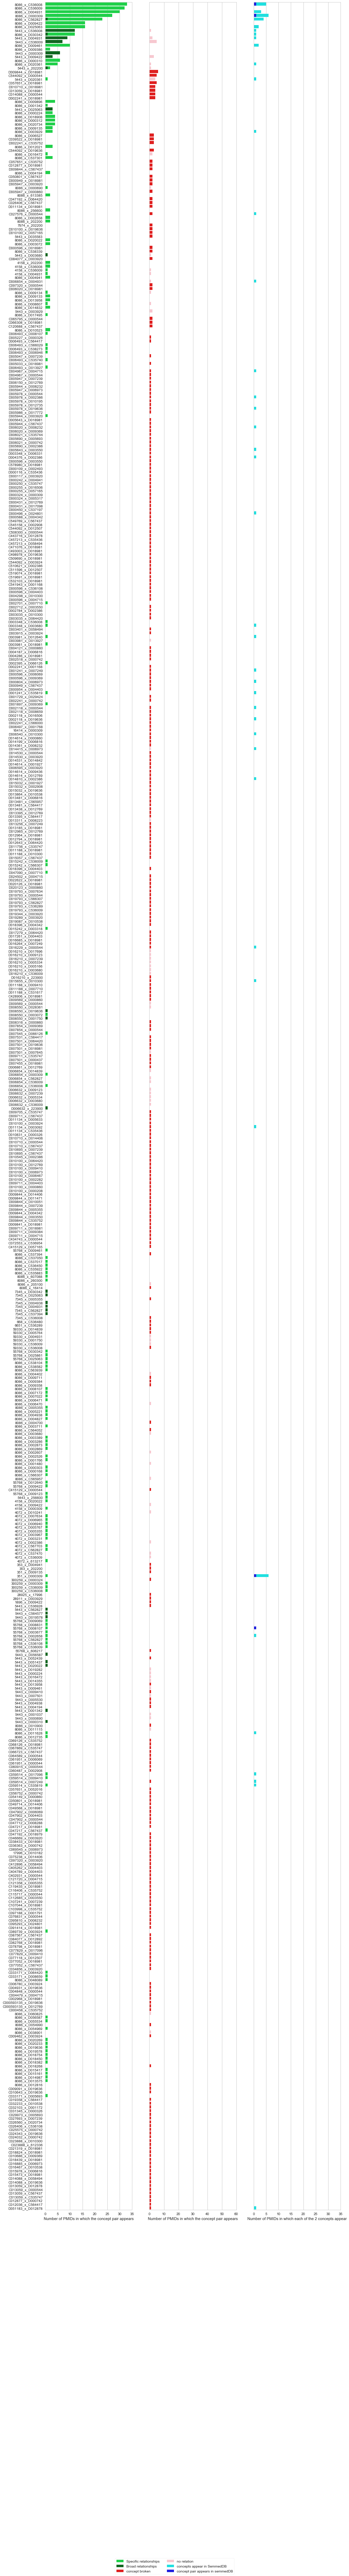

In [36]:
import seaborn as sns
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f = mplot.figure(figsize=(15,115))

# Plot the specific relationships involved
ax = mplot.subplot(1,3,1)
sns.set_color_codes("bright")
ax.yaxis.set_visible(True)
ax.xaxis.set_visible(True)
ax = sns.barplot(x="spec_rel", y="concept_pair", data=m2c_relation_cts,
            label="Specific relationships", color="g")

# Plot the broad relationships  involved
sns.set_color_codes("dark")
sns.barplot(x="broad_rel", y="concept_pair", data=m2c_relation_cts,
            label="Broad relationships", color="g")

ax.set(xlim=(0, 35), ylabel="",
       xlabel="Number of PMIDs in which the concept pair appears")

## Plot the broken and unrelated relationships
ax2 = mplot.subplot(1,3,2)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(True)
sns.set_color_codes("pastel")
ax2 = sns.barplot(x="cp_broken", y="concept_pair", data=m2c_relation_cts,
            label="concept broken", color="red")

sns.set_color_codes("bright")
sns.barplot(x="no_rel", y="concept_pair", data=m2c_relation_cts,
            label="no relation", color="pink")

ax2.set(xlim=(0, 60), ylabel="",
       xlabel="Number of PMIDs in which the concept pair appears")

# Plot the number of PMIDs in which both concepts were found in that pmid
sns.set_color_codes("muted")
ax3 = mplot.subplot(1,3,3)
ax3.yaxis.set_visible(False)
ax3.xaxis.set_visible(True)
ax3 = sns.barplot(x="sem_pmid_cts", y="concept_pair", data=semmed_cp_appear_df,
            label="concepts appear in SemmedDB", color="cyan")

sns.barplot(x="sem_true_cp_ct", y="concept_pair", data=semmed_cp_appear_df,
            label="concept pair appears in semmedDB", color="blue")

ax3.set(xlim=(0, 35), ylabel="",
       xlabel="Number of PMIDs in which each of the 2 concepts appear")

# Add a legend and informative axis label
f.legend(ncol=2, loc="lower center", frameon=True)
#sns.despine(left=True, bottom=True)
mplot.show()